In [119]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

# Лабораторная работа 4. Рекуррентные сети

В работе демонстрируется построение рекуррентной нейронной сети для посимвольной генерации текста.  

Полезные ссылки:
- [Andrej Karpathy – The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)
- [С. Николенко и др., 2018] – параграф 6.6.

In [182]:
import torch
import torch.nn as nn
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

Задаем параметры:

In [58]:
filename = 'onegin.txt'  # Входной файл с текстом

seq_len = 200            # Размер последовательности для одной эпохи
batch_size_train = 1     # Размер батча для обучения
batch_size_test = 1      # Размер батча для предсказания (всегда 1)
hidden_size = 100        # Размер скрытого состояния
embedding_size = 100     # Размер векторов-эмбеддингов для представления символов
num_layers = 1           # Количество слоев
lr = 0.005               # Скорость обучения
n_epochs = 1000          # Количество эпох
print_every = 100        # Интервал эпох для вывода результатов
plot_every = 10          # Интервал эпох для вывода потерь
predict_len = 200        # Количество символов для генерации

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

*Замечание*. Понятие "эпоха" обозначает период обработки всего обучающего множества. Но в контексте рекуррентных сетей это понятие может иметь значение, отличающееся от обычного, поскольку часто датасет бывает жестко не определен (например, из одного текста мы можем генерировать бесконечное количество последовательностей).  
Поэтому в данной лабораторной работе понятие "эпоха" обозначает период обработки всей последовательности размером `seq_len`.

---
Подготовьте входной текстовый файл. Можно взять ваше любимое художественное произведение.  
Здесь в качестве примера используется "Евгений Онегин".

In [60]:
with open(filename, encoding='utf-8') as f:
    data = f.read()
print(f'Длина текста: {len(data)} символов')
print(f'\nПервые {seq_len} строк:\n\n{data[:seq_len]}') # первые 200 символов

Длина текста: 144313 символов

Первые 200 строк:

ЕВГЕНИЙ ОНЕГИН

РОМАН В СТИХАХ

Petri  de  vanite  il  avait  encore plus de cette espece d'orgueil qui fait
avouer  avec  la  meme  indifference les bonnes comme les mauvaises actions,
suite d'un sen


---
Переводим текст в нижний регистр и создаем словарь всех символов:

In [61]:
data = data.lower()

vocabulary = set(data)
vocabulary = sorted(vocabulary)
print(f'Размер словаря: {len(vocabulary)}')
print(vocabulary)

Размер словаря: 82
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


---
Подготовим функцию для генерации случайных последовательностей длиной `seq_len+1` из входного текста.  
Единица прибавляется, так как в дальнейшем мы будем из этой сгенерированной последовательности получать две:
- *обучающую*, без последнего символа,
- *предсказываемую*, без первого символа.  

Таким образом, предсказываемая последовательность будет как бы сдвинута относительно обучающей на единицу вправо и каждый символ предсказываемой последовательности будет являться следующим символом для соответствующего обучающего символа.  
Обе последовательности будут на единицу меньше исходной последовательности.

In [62]:
def random_sequence(data, seq_len):
    start_index = random.randint(0, len(data) - seq_len - 1)
    end_index = start_index + seq_len + 1
    return data[start_index:end_index]

sequence = random_sequence(data, seq_len)
print(f'length = {len(sequence)}\n\n{sequence}')

length = 201

м и нежным?
ужели не простите ей
вы легкомыслия страстей?

xxv

кокетка судит хладнокровно,
татьяна любит не шутя
и предается безусловно
любви, как милое дитя.
не говорит она: отложим -
любви мы цену т


---
Задаем модель:

In [63]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)
        
        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.rnn(embeddings, hidden)
        
        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)
        
        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Класс `Embedding` используется для формирования векторного представления каких-либо элементов (символов, слов, изображений, звуков и т.п.). Он представляет собой линейный слой, на вход которого поступают индексы элементов, а на выходе он выдает векторное представление этих элементов ([справка PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)).  
Слой `Embedding` имеет свою матрицу весов, которые настраиваются в процессе обучения. Веса инициализируются из нормального распределения $N(0,1)$.  
После обучения слой `Embedding` будет содержать веса, в каком-то смысле "хорошо" представляющие входные элементы для текущей задачи.  
Данный слой при создании требует двух основных параметров:
- `num_embeddings` – размер словаря элементов (общее количество элементов, которые мы хотим закодировать);
- `embedding_dim` – размерность выходных векторов.  

Слой `Embedding` является, по сути, аналогом обычного слоя `Linear`, но `Linear` на входе ожидает вектор (например, *one-hot encoding* представление элементов), а на входе `Embedding` – тензоры любой размерности, содержащие просто индексы элементов, для которых необходимо получить векторное представление:

In [64]:
# Пример
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
print(f'embedding.weight:\n{embedding.weight.data}')

i = torch.tensor(5)
print(f'\nВектор для элемента с индексом {i}:\n{embedding(i).data}')

array = torch.tensor([[1, 2], [4, 5]])
print(f'\nВекторы для массива индексов:\n{embedding(array).data}')

embedding.weight:
tensor([[ 8.3294e-01, -1.7592e-01, -2.6073e-02],
        [ 1.5929e+00,  7.7552e-02,  7.0664e-01],
        [ 1.7032e+00, -3.7357e-01, -1.7581e-02],
        [ 4.7182e-01, -6.7467e-01,  3.8534e-01],
        [-1.6048e-03,  1.2848e+00, -3.4958e-01],
        [ 1.3039e+00, -4.7465e-01,  5.4457e-02],
        [-1.9188e-01, -3.8000e-01,  4.3031e-01],
        [ 9.8830e-01, -1.5177e+00,  8.7337e-01],
        [-7.0013e-02, -9.6082e-01,  3.9926e-01],
        [-1.8549e+00, -7.4532e-01, -1.0411e+00]])

Вектор для элемента с индексом 5:
tensor([ 1.3039, -0.4746,  0.0545])

Векторы для массива индексов:
tensor([[[ 1.5929e+00,  7.7552e-02,  7.0664e-01],
         [ 1.7032e+00, -3.7357e-01, -1.7581e-02]],

        [[-1.6048e-03,  1.2848e+00, -3.4958e-01],
         [ 1.3039e+00, -4.7465e-01,  5.4457e-02]]])


---
В итоге, модель будет выглядеть следующим образом:  

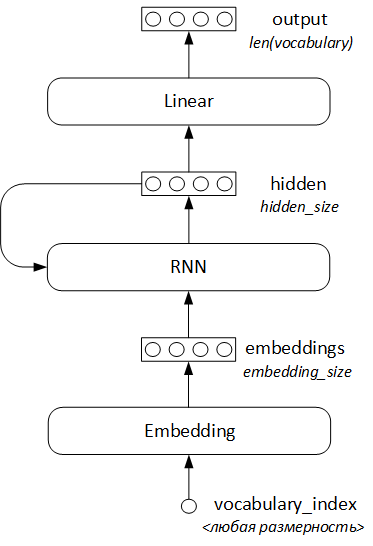

---
Функция, которая по входной строке возвращает список индексов из словаря `vocabulary`:

In [65]:
def char_to_tensor(string, vocabulary):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = vocabulary.index(string[c])
    return tensor

indices = char_to_tensor('онегин', vocabulary).to(device)
print(indices)

tensor([64, 63, 55, 53, 58, 63], device='cuda:0')


Напишем также функцию для обратного преобразования из списка индексов в строку:

In [66]:
def tensor_to_char(tensor, vocabulary):
    s = ''
    for t in tensor:
        s += vocabulary[int(t)]
    return s

print(tensor_to_char(indices, vocabulary))

онегин


---
Напишем функцию для генерации пары (входная последовательность, выходная последовательность).  
В качестве входной (обучающей) последовательности выступает случайная строка без последнего символа;  
выходная последовательность – та же строка без первого символа.  
Таким образом, каждому элементу входной последовательности (символу) соответствует элемент выходной последовательности (символ), который является следующим символом в строке.  
Выходная последовательность является целевой переменной, именно её сеть будет пытаться предсказать.  
Размер каждой последовательности – `seq_len`.

In [67]:
def random_training_set(data, seq_len, vocabulary):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    return input, target

In [68]:
input, target = random_training_set(data, seq_len, vocabulary)

print(f'********** input ({len(input)})**********\n\n{input.data}')
print(f'\n********** target ({len(target)}) **********\n{target.data}')

********** input (200)**********

tensor([55,  1, 63, 50,  1, 60, 66, 77, 61, 78, 72, 55,  0, 67,  1, 67, 55, 62,
        58, 63, 50, 66, 58, 67, 68, 64, 62,  1, 52,  1, 56, 55, 61, 68, 64, 59,
         1, 74, 50, 61, 55,  0, 58, 61, 78,  1, 67,  1, 50, 60, 50, 54, 55, 62,
        58, 60, 64, 62,  1, 52,  1, 73, 55, 65, 72, 55,  2,  0, 60, 50, 60,  1,
        69, 67, 68,  1, 66, 69, 62, 81, 63, 77, 71,  1, 51, 55, 57,  1, 69, 61,
        77, 51, 60, 58,  7,  0, 51, 55, 57,  1, 53, 66, 50, 62, 62, 50, 68, 58,
        73, 55, 67, 60, 64, 59,  1, 64, 74, 58, 51, 60, 58,  0, 81,  1, 66, 69,
        67, 67, 60, 64, 59,  1, 66, 55, 73, 58,  1, 63, 55,  1, 61, 80, 51, 61,
        80,  9,  0, 51, 77, 68, 78,  1, 62, 64, 56, 55, 68,  7,  1, 63, 50,  1,
        51, 55, 54, 69,  1, 62, 64, 80,  7,  0, 60, 66, 50, 67, 50, 52, 58, 72,
         1, 63, 64, 52, 77, 71,  1, 65, 64, 60, 64, 61, 55, 63, 78, 55,  7,  0,
        56, 69])

********** target (200) **********
tensor([ 1, 63, 50,  1, 60, 66, 7

Преобразуем полученные тензоры в строки:

In [69]:
print(f'********** input **********\n\n{tensor_to_char(input, vocabulary)}')
print(f'\n********** target **********\n\n{tensor_to_char(target, vocabulary)}')

********** input **********

е на крыльце
с семинаристом в желтой шале
иль с академиком в чепце!
как уст румяных без улыбки,
без грамматической ошибки
я русской речи не люблю.
быть может, на беду мою,
красавиц новых поколенье,
жу

********** target **********

 на крыльце
с семинаристом в желтой шале
иль с академиком в чепце!
как уст румяных без улыбки,
без грамматической ошибки
я русской речи не люблю.
быть может, на беду мою,
красавиц новых поколенье,
жур


---
RNN требует на вход трехмерный тензор размерностью: `(seq_len, batch_size, input_size)`:
\
\
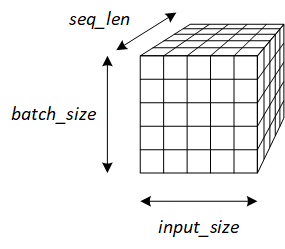


Таким образом, последовательности символов будут располагаться вдоль размерности `seq_len`.

Этот трехмерный тензор подается на вход RNN по мини-батчам:
\
\
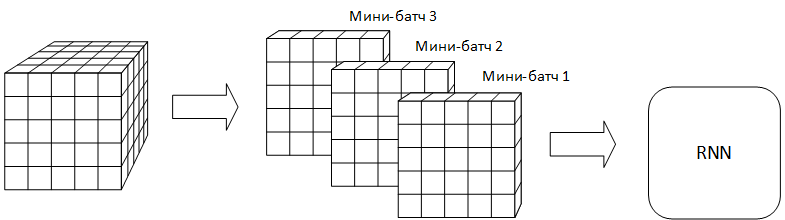

Каждый мини-батч обрабатывается в RNN одновременно; при этом формируется столько же скрытых состояний, сколько векторов в мини-батче. Эти скрытые состояния также являются выходами RNN: на каждый вектор мини-батча – свой выходной вектор (он же скрытое состояние).

В нашем примере:
- `input_size = 1` – на вход подается только индекс текущего символа в словаре, который в слое `Embedding` преобразуется в вектор размерности `embedding_size`;
- `batch_size = batch_size_train` – размер мини-батча;
- `seq_len = 200` – длина последовательности символов на одном шаге:
\
\
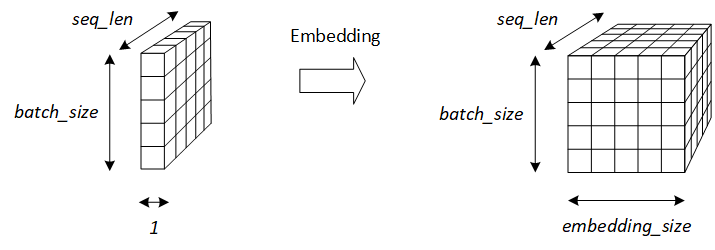

---
Зададим функцию обучения для одной эпохи – это процедура обработки в RNN всех мини-батчей, входящих в последовательность размером `seq_len`. Каждый мини-батч включает всего один индекс символа в словаре.  

Инициализация (обнуление) скрытого состояния происходит в начале каждого шага. Существует две стратегии инициализации скрытого состояния:
1. Если обрабатываются продолжительные непрерывные входные данные (например, "Война и мир"), разбитые на последовательности, и последовательность на текущем шаге является продолжением последовательности на предыдущем шаге, то скрытые состояния можно передавать с предыдущей эпохи (после обработки всей последовательности).
1. Если датасет состоит из отдельных последовательностей, не связанных между собой (например, твитов), то скрытое состояние желательно обнулять перед каждой эпохой.  

В нашем примере последовательности для каждой эпохи формируются независимо друг от друга, поэтому скрытые состояния обнуляются.

In [70]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size).to(device)
    check_device_tensor(hidden)
    
    rnn.zero_grad()
    loss = 0
    
    outputs, hidden = rnn(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1).to(device)
    target = target.view(seq_len * batch_size).to(device)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

---
Операция `view` в PyTorch создает новый тензор как "представление" существущего тензора: сами данные никуда не копируются, но размерность данных меняется. Таким образом, экономятся память и время.

In [71]:
# Пример
t = torch.rand(2, 2)
print(f'Исходный тензор:\n{t}')

b = t.view(1, -1)
print(f'\nТензор-представление (view):\n{b}')

# Данные в обоих тензорах разделяются
print(f'\nДанные совпадают? - {t.storage().data_ptr() == b.storage().data_ptr()}')

# Изменение тензора-представления изменяет базовый тензор
b[0][1] = 1
print(f'\nИсходный тензор:\n{t}')

# Растягиваем двумерный тензор в одномерный
b = b.view(-1)
print(f'\nОдномерный тензор:\n{b}')

Исходный тензор:
tensor([[0.0862, 0.0215],
        [0.9417, 0.3854]])

Тензор-представление (view):
tensor([[0.0862, 0.0215, 0.9417, 0.3854]])

Данные совпадают? - True

Исходный тензор:
tensor([[0.0862, 1.0000],
        [0.9417, 0.3854]])

Одномерный тензор:
tensor([0.0862, 1.0000, 0.9417, 0.3854])


---
Напишем функцию, генерирующую текст длины `predict_len` с началом (префиксной строкой) `prefix`.  
Результирующая строка будет иметь вид: `prefix` + сгенерированная строка.

In [72]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size).to(device)
    check_device_tensor(hidden, "evaluate, hidden")
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary).to(device)
    check_device_tensor(prefix_input, "evaluate, prefix_input")
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        check_device_tensor(input, "evaluate, input1")
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)
    check_device_tensor(input, "evaluate, input2")

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp().to(device)
        check_device_tensor(output_dist, "evaluate, output_dist")
        top_index = torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)
        check_device_tensor(input, "evaluate, input3")

    return predicted

Вспомогательная функция для вывода времени:

In [73]:
def time_since(since):
    seconds = time.time() - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min {seconds:.0f} sec'

---
Основная процедура обучения и генерации примеров текста в процессе обучения.  
Генерация текстов в ходе обучения необходима только для иллюстрации изменений возможностей модели по мере обучения.

In [74]:
def check_device(model):
    for parameter in model.named_parameters():
        print(f'{parameter[0]} on Cuda: {parameter[1].data.is_cuda}')

In [75]:
def check_device_tensor(tens, text="none"):
    if not tens.is_cuda:
        print(f"Cuda: {tens.is_cuda}, {text}")

In [76]:
#check_device(rnn)

In [77]:
# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)
rnn.to(device)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):
    
    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1).to(device)
    target = target.view(-1, 1).to(device)
    check_device_tensor(input)
    check_device_tensor(target)
    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1).to(device)
        target_seq = target_seq.view(-1, 1).to(device)
        check_device_tensor(sequence)
        check_device_tensor(target_seq)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)
        check_device_tensor(input)
        check_device_tensor(target)
    
    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss.to('cpu')

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:
        
        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')
        
        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 1 sec, epochs = 100 (10.0%), loss = 0.0136]
а, ним эно ниискра,,
вздиты он сеграены
ялидете, прог
бома толуммой отмилоду грых дxx
vviiii;
ух баразнокила, нег бравильу,
- кошись ко сврязно бгита
- ващон вскиткя{.е
кися дейбывенте;
мородати,
плили

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0119]
ай,
прые находь них жали вско в ше да и позвадья,
стохде баерой воесту холька но и ел;
восовств,
чед рища
и смя не в бединьгокой, и вседято назам
пострудену;
и вистваеле
ченьямы,
. нам;
неда нетая
но э

[time = 0 min 4 sec, epochs = 300 (30.0%), loss = 0.0114]
амно нем новно воздрусвеить его семой ограсныг лялир двнова пробляние,
в подому ведзаны свозчувий осмиталедвевать нажорона прил:
юпрег рфолсленькая
татью, эев не свор ног . . неду.
ноб"и,
на пдоче вной

[time = 0 min 6 sec, epochs = 400 (40.0%), loss = 0.0117]
а совалска ги лашном
в прем и онец ещих слочан о всег сма, уж подной цатьи;
с жал гос ота! хой их бодав омен нак сезразцем евась надрудца, сехоршыный укой, не 

---
Рисуем график потерь:

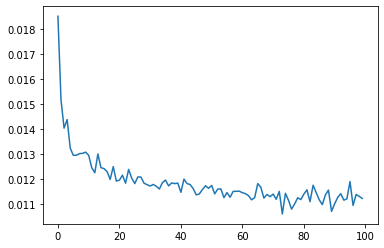

In [78]:
plt.figure()
plt.plot(all_losses)

После обучения можно подставить любое начало и сеть его продолжит:

In [79]:
beginning = 'мой дядя лучший тракторист'.lower()

predict = evaluate(
    model=rnn,
    vocabulary=vocabulary,
    batch_size=batch_size_test,
    prefix=beginning,
    predict_len=predict_len
)

print(predict)

мой дядя лучший трактористровы
и карых,
заклись, он он отледит давый талины веляд.
у иготаям жее,
иль?.".
уто тевей:
ты кака!
ди же что мотрен
чисто блеча, костал. чеженких нем на 
стой,
песткима
дере? тольца стердца можите чи


---
#### Задание 1.
Перенесите модель и данные на GPU.

already

#### Задание 2.
Запустите обучение модели с разным количеством эпох и размером мини-батча. Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [80]:
list_epochs = [1000, 5000] # 10000 15000 -> part2
list_batch_size_train = [3, 7, 12, 20]

In [81]:
current_params = {
    'learning_time' : None,
    'epochs' : None,
    'batch_size' : None,
    'text' : None,
}

In [83]:
file = open("rnn_results_part1.txt", "a", encoding="utf-8")
for ep in list_epochs:
    for bs_train in list_batch_size_train:
        # Создаем модель
        rnn = RNN(
            input_size=len(vocabulary),
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            output_size=len(vocabulary),
            num_layers=num_layers
        )
        rnn.to(device)      # Переносим модель на гпу
        rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        start = time.time()  # Начало замера времени
        prefix = 'а'         # Префиксная строка для генерации в процессе обучения.
        all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
        loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика
        for epoch in range(1, ep + 1):
            # Генерируем первую последовательность
            input, target = random_training_set(data, seq_len, vocabulary)
            input = input.view(-1, 1).to(device)
            target = target.view(-1, 1).to(device)
            # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
            for b in range(bs_train-1):
                sequence, target_seq = random_training_set(data, seq_len, vocabulary)
                sequence = sequence.view(-1, 1).to(device)
                target_seq = target_seq.view(-1, 1).to(device)
                input = torch.cat((input, sequence), dim=1)
                target = torch.cat((target, target_seq), dim=1)
            # Запускаем эпоху обучения
            loss = train(input, target, bs_train)
            loss_avg += loss
            # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
            if epoch % print_every == 0:
                print(f'[time = {time_since(start)}, epochs = {epoch} ({(epoch / ep * 100):.4}%), loss = {loss:.4f}]')
                predicted_text = evaluate(
                    model=rnn,
                    vocabulary=vocabulary,
                    batch_size=batch_size_test,
                    prefix=prefix,
                    predict_len=predict_len
                )
                #print(predicted_text)
                #print()
            if epoch % plot_every == 0:
                all_losses.append(loss_avg / plot_every)
                loss_avg = 0
        # записываем текущие параметры, время обучения и генерируем текст
        current_params = {
            'learning_time' : time_since(start),
            'epochs' : ep,
            'batch_size' : bs_train,
            'text' : evaluate(
                        model=rnn,
                        vocabulary=vocabulary,
                        batch_size=batch_size_test,
                        prefix=beginning,
                        predict_len=predict_len
                    )
        }
        file.write(str(current_params)+"\n")
file.close()

[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0121]
[time = 0 min 4 sec, epochs = 200 (20.0%), loss = 0.0117]
[time = 0 min 6 sec, epochs = 300 (30.0%), loss = 0.0109]
[time = 0 min 9 sec, epochs = 400 (40.0%), loss = 0.0115]
[time = 0 min 11 sec, epochs = 500 (50.0%), loss = 0.0110]
[time = 0 min 13 sec, epochs = 600 (60.0%), loss = 0.0109]
[time = 0 min 15 sec, epochs = 700 (70.0%), loss = 0.0117]
[time = 0 min 18 sec, epochs = 800 (80.0%), loss = 0.0104]
[time = 0 min 20 sec, epochs = 900 (90.0%), loss = 0.0102]
[time = 0 min 22 sec, epochs = 1000 (100.0%), loss = 0.0100]
[time = 0 min 4 sec, epochs = 100 (10.0%), loss = 0.0118]
[time = 0 min 8 sec, epochs = 200 (20.0%), loss = 0.0113]
[time = 0 min 12 sec, epochs = 300 (30.0%), loss = 0.0109]
[time = 0 min 16 sec, epochs = 400 (40.0%), loss = 0.0105]
[time = 0 min 20 sec, epochs = 500 (50.0%), loss = 0.0098]
[time = 0 min 25 sec, epochs = 600 (60.0%), loss = 0.0104]
[time = 0 min 29 sec, epochs = 700 (70.0%), loss = 0.0100]
[

[time = 3 min 26 sec, epochs = 4900 (98.0%), loss = 0.0095]
[time = 3 min 30 sec, epochs = 5000 (100.0%), loss = 0.0089]
[time = 0 min 6 sec, epochs = 100 (2.0%), loss = 0.0115]
[time = 0 min 12 sec, epochs = 200 (4.0%), loss = 0.0106]
[time = 0 min 18 sec, epochs = 300 (6.0%), loss = 0.0108]
[time = 0 min 24 sec, epochs = 400 (8.0%), loss = 0.0106]
[time = 0 min 30 sec, epochs = 500 (10.0%), loss = 0.0099]
[time = 0 min 37 sec, epochs = 600 (12.0%), loss = 0.0091]
[time = 0 min 44 sec, epochs = 700 (14.0%), loss = 0.0100]
[time = 0 min 50 sec, epochs = 800 (16.0%), loss = 0.0100]
[time = 0 min 56 sec, epochs = 900 (18.0%), loss = 0.0101]
[time = 1 min 3 sec, epochs = 1000 (20.0%), loss = 0.0096]
[time = 1 min 10 sec, epochs = 1100 (22.0%), loss = 0.0096]
[time = 1 min 16 sec, epochs = 1200 (24.0%), loss = 0.0095]
[time = 1 min 22 sec, epochs = 1300 (26.0%), loss = 0.0093]
[time = 1 min 29 sec, epochs = 1400 (28.0%), loss = 0.0094]
[time = 1 min 35 sec, epochs = 1500 (30.0%), loss = 0.

#### Задание 3.
Поменяйте модуль Simple RNN на LSTM. Запустите обучение модели с разным количеством эпох и размером мини-батча.  
Желательно, чтобы параметры совпадали с предыдущим экспериментом и можно было сравнивать модели.  
Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [114]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)
        
        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.lstm(embeddings, hidden)
        
        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)
        
        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device), \
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

In [115]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = lstm.init_hidden(batch_size=batch_size)
    
    lstm.zero_grad()
    loss = 0
    
    outputs, hidden = lstm(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1).to(device)
    target = target.view(seq_len * batch_size).to(device)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    lstm_optimizer.step()

    return loss.data / len(input)

In [116]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary).to(device)
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp().to(device)
        top_index = torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [118]:
file = open("lstm_results_part1.txt", "a", encoding="utf-8")
for ep in list_epochs:
    for bs_train in list_batch_size_train:
        # Создаем модель
        lstm = LSTM(
            input_size=len(vocabulary),
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            output_size=len(vocabulary),
            num_layers=num_layers
        )
        lstm.to(device)      # Переносим модель на гпу
        lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        start = time.time()  # Начало замера времени
        prefix = 'а'         # Префиксная строка для генерации в процессе обучения.
        all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
        loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика
        for epoch in range(1, ep + 1):
            # Генерируем первую последовательность
            input, target = random_training_set(data, seq_len, vocabulary)
            input = input.view(-1, 1).to(device)
            target = target.view(-1, 1).to(device)
            # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
            for b in range(bs_train-1):
                sequence, target_seq = random_training_set(data, seq_len, vocabulary)
                sequence = sequence.view(-1, 1).to(device)
                target_seq = target_seq.view(-1, 1).to(device)
                input = torch.cat((input, sequence), dim=1)
                target = torch.cat((target, target_seq), dim=1)
            # Запускаем эпоху обучения
            loss = train(input, target, bs_train)
            loss_avg += loss
            # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
            if epoch % print_every == 0:
                print(f'[time = {time_since(start)}, epochs = {epoch} ({(epoch / ep * 100):.4}%), loss = {loss:.4f}]')
                predicted_text = evaluate(
                    model=lstm,
                    vocabulary=vocabulary,
                    batch_size=batch_size_test,
                    prefix=prefix,
                    predict_len=predict_len
                )
                #print(predicted_text)
                #print()
            if epoch % plot_every == 0:
                all_losses.append(loss_avg / plot_every)
                loss_avg = 0
        # записываем текущие параметры, время обучения и генерируем текст
        current_params = {
            'learning_time' : time_since(start),
            'epochs' : ep,
            'batch_size' : bs_train,
            'text' : evaluate(
                        model=lstm,
                        vocabulary=vocabulary,
                        batch_size=batch_size_test,
                        prefix=beginning,
                        predict_len=predict_len
                    )
        }
        file.write(str(current_params)+"\n")
file.close()
print("Done")

[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0125]
[time = 0 min 4 sec, epochs = 200 (20.0%), loss = 0.0116]
[time = 0 min 6 sec, epochs = 300 (30.0%), loss = 0.0098]
[time = 0 min 9 sec, epochs = 400 (40.0%), loss = 0.0106]
[time = 0 min 11 sec, epochs = 500 (50.0%), loss = 0.0113]
[time = 0 min 13 sec, epochs = 600 (60.0%), loss = 0.0108]
[time = 0 min 15 sec, epochs = 700 (70.0%), loss = 0.0113]
[time = 0 min 18 sec, epochs = 800 (80.0%), loss = 0.0103]
[time = 0 min 20 sec, epochs = 900 (90.0%), loss = 0.0105]
[time = 0 min 22 sec, epochs = 1000 (100.0%), loss = 0.0098]
[time = 0 min 4 sec, epochs = 100 (10.0%), loss = 0.0120]
[time = 0 min 8 sec, epochs = 200 (20.0%), loss = 0.0114]
[time = 0 min 12 sec, epochs = 300 (30.0%), loss = 0.0109]
[time = 0 min 16 sec, epochs = 400 (40.0%), loss = 0.0102]
[time = 0 min 21 sec, epochs = 500 (50.0%), loss = 0.0103]
[time = 0 min 25 sec, epochs = 600 (60.0%), loss = 0.0101]
[time = 0 min 29 sec, epochs = 700 (70.0%), loss = 0.0096]
[

[time = 3 min 30 sec, epochs = 4900 (98.0%), loss = 0.0083]
[time = 3 min 35 sec, epochs = 5000 (100.0%), loss = 0.0078]
[time = 0 min 7 sec, epochs = 100 (2.0%), loss = 0.0119]
[time = 0 min 13 sec, epochs = 200 (4.0%), loss = 0.0114]
[time = 0 min 19 sec, epochs = 300 (6.0%), loss = 0.0101]
[time = 0 min 25 sec, epochs = 400 (8.0%), loss = 0.0096]
[time = 0 min 31 sec, epochs = 500 (10.0%), loss = 0.0099]
[time = 0 min 37 sec, epochs = 600 (12.0%), loss = 0.0097]
[time = 0 min 43 sec, epochs = 700 (14.0%), loss = 0.0093]
[time = 0 min 50 sec, epochs = 800 (16.0%), loss = 0.0096]
[time = 0 min 56 sec, epochs = 900 (18.0%), loss = 0.0094]
[time = 1 min 2 sec, epochs = 1000 (20.0%), loss = 0.0093]
[time = 1 min 8 sec, epochs = 1100 (22.0%), loss = 0.0095]
[time = 1 min 14 sec, epochs = 1200 (24.0%), loss = 0.0091]
[time = 1 min 20 sec, epochs = 1300 (26.0%), loss = 0.0089]
[time = 1 min 26 sec, epochs = 1400 (28.0%), loss = 0.0079]
[time = 1 min 32 sec, epochs = 1500 (30.0%), loss = 0.0

#### Задание 4.
Повторите предыдущее задание для модуля GRU.  
Кроме выводов об эффективности, сделайте выводы о времени обучения разных моделей – Simple RNN, LSTM, GRU.

In [152]:
class GRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        
        super(GRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)
        
        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.gru(embeddings, hidden)
        
        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)
        
        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [153]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = gru.init_hidden(batch_size=batch_size)
    
    gru.zero_grad()
    loss = 0
    
    outputs, hidden = gru(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1).to(device)
    target = target.view(seq_len * batch_size).to(device)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    gru_optimizer.step()

    return loss.data / len(input)

In [154]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary).to(device)
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp().to(device)
        top_index = torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [ ]:
file = open("gru_results_part1.txt", "a", encoding="utf-8")
for ep in list_epochs:
    for bs_train in list_batch_size_train:
        # Создаем модель
        gru = GRU(
            input_size=len(vocabulary),
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            output_size=len(vocabulary),
            num_layers=num_layers
        )
        gru.to(device)      # Переносим модель на гпу
        gru_optimizer = torch.optim.Adam(gru.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        start = time.time()  # Начало замера времени
        prefix = 'а'         # Префиксная строка для генерации в процессе обучения.
        all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
        loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика
        for epoch in range(1, ep + 1):
            # Генерируем первую последовательность
            input, target = random_training_set(data, seq_len, vocabulary)
            input = input.view(-1, 1).to(device)
            target = target.view(-1, 1).to(device)
            # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
            for b in range(bs_train-1):
                sequence, target_seq = random_training_set(data, seq_len, vocabulary)
                sequence = sequence.view(-1, 1).to(device)
                target_seq = target_seq.view(-1, 1).to(device)
                input = torch.cat((input, sequence), dim=1)
                target = torch.cat((target, target_seq), dim=1)
            # Запускаем эпоху обучения
            loss = train(input, target, bs_train)
            loss_avg += loss
            # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
            if epoch % print_every == 0:
                print(f'[time = {time_since(start)}, epochs = {epoch} ({(epoch / ep * 100):.4f}%), loss = {loss:.4f}]')
                predicted_text = evaluate(
                    model=gru,
                    vocabulary=vocabulary,
                    batch_size=batch_size_test,
                    prefix=prefix,
                    predict_len=predict_len
                )
                #print(predicted_text)
                #print()
            if epoch % plot_every == 0:
                all_losses.append(loss_avg / plot_every)
                loss_avg = 0
        # записываем текущие параметры, время обучения и генерируем текст
        current_params = {
            'learning_time' : time_since(start),
            'epochs' : ep,
            'batch_size' : bs_train,
            'text' : evaluate(
                        model=gru,
                        vocabulary=vocabulary,
                        batch_size=batch_size_test,
                        prefix=beginning,
                        predict_len=predict_len
                    )
        }
        file.write(str(current_params)+"\n")
file.close()
print("Done")

#### Задание 5.
Выберите лучшую модель по результатам предыдущих экспериментов и попробуйте добиться повышения качества за счёт разного количества слоёв.

In [156]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = gru.init_hidden(batch_size=batch_size)
    
    gru.zero_grad()
    loss = 0
    
    outputs, hidden = gru(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1).to(device)
    target = target.view(seq_len * batch_size).to(device)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    gru_optimizer.step()

    return loss.data / len(input)

In [196]:
def sampling(preds, t=1.0):
    preds = np.asarray(preds.to('cpu').numpy()).astype('float64')
    preds = np.log(preds) / t
    preds = np.nan_to_num(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [193]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100, temperature=1):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary).to(device)
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        #output_dist = output_dist.exp()
        top_index = sampling(output_dist, temperature) #torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [172]:
num_layers = 7
n_epochs = 50000
batch_size_train = 20

In [173]:
file = open("top_gru_results.txt", "w", encoding="utf-8")
# Создаем модель
gru = GRU(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)
gru.to(device)      # Переносим модель на гпу
gru_optimizer = torch.optim.Adam(gru.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
start = time.time()  # Начало замера времени
prefix = 'а'         # Префиксная строка для генерации в процессе обучения.
all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика
for epoch in range(1, n_epochs + 1):
    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1).to(device)
    target = target.view(-1, 1).to(device)
    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1).to(device)
        target_seq = target_seq.view(-1, 1).to(device)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)
    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss
    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:
        print(f'[time = {time_since(start)}, epochs = {epoch} ({(epoch / n_epochs * 100):.4}%), loss = {loss:.4f}]')
        predicted_text = evaluate(
            model=gru,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        #print(predicted_text)
        #print()
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
# записываем текущие параметры, время обучения и генерируем текст
current_params = {
    'learning_time' : time_since(start),
    'epochs' : ep,
    'batch_size' : bs_train,
    'text' : evaluate(
                model=gru,
                vocabulary=vocabulary,
                batch_size=batch_size_test,
                prefix=beginning,
                predict_len=predict_len
            )
}
file.write(current_params['text'])
file.close()
print("Done")

[time = 0 min 12 sec, epochs = 100 (0.2%), loss = 0.0167]
[time = 0 min 24 sec, epochs = 200 (0.4%), loss = 0.0166]
[time = 0 min 35 sec, epochs = 300 (0.6%), loss = 0.0165]
[time = 0 min 47 sec, epochs = 400 (0.8%), loss = 0.0162]
[time = 0 min 59 sec, epochs = 500 (1.0%), loss = 0.0161]
[time = 1 min 11 sec, epochs = 600 (1.2%), loss = 0.0151]
[time = 1 min 23 sec, epochs = 700 (1.4%), loss = 0.0149]
[time = 1 min 35 sec, epochs = 800 (1.6%), loss = 0.0146]
[time = 1 min 47 sec, epochs = 900 (1.8%), loss = 0.0126]
[time = 1 min 59 sec, epochs = 1000 (2.0%), loss = 0.0117]
[time = 2 min 11 sec, epochs = 1100 (2.2%), loss = 0.0115]
[time = 2 min 23 sec, epochs = 1200 (2.4%), loss = 0.0117]
[time = 2 min 35 sec, epochs = 1300 (2.6%), loss = 0.0116]
[time = 2 min 47 sec, epochs = 1400 (2.8%), loss = 0.0111]
[time = 2 min 59 sec, epochs = 1500 (3.0%), loss = 0.0109]
[time = 3 min 11 sec, epochs = 1600 (3.2%), loss = 0.0111]
[time = 3 min 23 sec, epochs = 1700 (3.4%), loss = 0.0106]
[time 

[time = 28 min 20 sec, epochs = 13700 (27.4%), loss = 0.0086]
[time = 28 min 32 sec, epochs = 13800 (27.6%), loss = 0.0087]
[time = 28 min 45 sec, epochs = 13900 (27.8%), loss = 0.0079]
[time = 28 min 57 sec, epochs = 14000 (28.0%), loss = 0.0083]
[time = 29 min 9 sec, epochs = 14100 (28.2%), loss = 0.0084]
[time = 29 min 21 sec, epochs = 14200 (28.4%), loss = 0.0087]
[time = 29 min 34 sec, epochs = 14300 (28.6%), loss = 0.0086]
[time = 29 min 47 sec, epochs = 14400 (28.8%), loss = 0.0084]
[time = 30 min 6 sec, epochs = 14500 (29.0%), loss = 0.0086]
[time = 30 min 22 sec, epochs = 14600 (29.2%), loss = 0.0089]
[time = 30 min 34 sec, epochs = 14700 (29.4%), loss = 0.0085]
[time = 30 min 46 sec, epochs = 14800 (29.6%), loss = 0.0084]
[time = 30 min 58 sec, epochs = 14900 (29.8%), loss = 0.0088]
[time = 31 min 10 sec, epochs = 15000 (30.0%), loss = 0.0089]
[time = 31 min 22 sec, epochs = 15100 (30.2%), loss = 0.0086]
[time = 31 min 34 sec, epochs = 15200 (30.4%), loss = 0.0086]
[time = 31

[time = 56 min 19 sec, epochs = 27000 (54.0%), loss = 0.0090]
[time = 56 min 32 sec, epochs = 27100 (54.2%), loss = 0.0094]
[time = 56 min 44 sec, epochs = 27200 (54.4%), loss = 0.0097]
[time = 56 min 56 sec, epochs = 27300 (54.6%), loss = 0.0097]
[time = 57 min 8 sec, epochs = 27400 (54.8%), loss = 0.0093]
[time = 57 min 21 sec, epochs = 27500 (55.0%), loss = 0.0092]
[time = 57 min 33 sec, epochs = 27600 (55.2%), loss = 0.0091]
[time = 57 min 45 sec, epochs = 27700 (55.4%), loss = 0.0086]
[time = 57 min 57 sec, epochs = 27800 (55.6%), loss = 0.0095]
[time = 58 min 9 sec, epochs = 27900 (55.8%), loss = 0.0089]
[time = 58 min 22 sec, epochs = 28000 (56.0%), loss = 0.0093]
[time = 58 min 34 sec, epochs = 28100 (56.2%), loss = 0.0093]
[time = 58 min 47 sec, epochs = 28200 (56.4%), loss = 0.0092]
[time = 58 min 59 sec, epochs = 28300 (56.6%), loss = 0.0091]
[time = 59 min 12 sec, epochs = 28400 (56.8%), loss = 0.0096]
[time = 59 min 24 sec, epochs = 28500 (57.0%), loss = 0.0088]
[time = 59

[time = 84 min 23 sec, epochs = 40300 (80.6%), loss = 0.0092]
[time = 84 min 36 sec, epochs = 40400 (80.8%), loss = 0.0095]
[time = 84 min 50 sec, epochs = 40500 (81.0%), loss = 0.0099]
[time = 85 min 3 sec, epochs = 40600 (81.2%), loss = 0.0099]
[time = 85 min 16 sec, epochs = 40700 (81.4%), loss = 0.0099]
[time = 85 min 29 sec, epochs = 40800 (81.6%), loss = 0.0093]
[time = 85 min 43 sec, epochs = 40900 (81.8%), loss = 0.0095]
[time = 85 min 56 sec, epochs = 41000 (82.0%), loss = 0.0099]
[time = 86 min 9 sec, epochs = 41100 (82.2%), loss = 0.0096]
[time = 86 min 22 sec, epochs = 41200 (82.4%), loss = 0.0099]
[time = 86 min 35 sec, epochs = 41300 (82.6%), loss = 0.0096]
[time = 86 min 49 sec, epochs = 41400 (82.8%), loss = 0.0097]
[time = 87 min 2 sec, epochs = 41500 (83.0%), loss = 0.0096]
[time = 87 min 15 sec, epochs = 41600 (83.2%), loss = 0.0097]
[time = 87 min 28 sec, epochs = 41700 (83.4%), loss = 0.0096]
[time = 87 min 41 sec, epochs = 41800 (83.6%), loss = 0.0098]
[time = 87 

In [197]:
pred = evaluate(
                model=gru,
                vocabulary=vocabulary,
                batch_size=batch_size_test,
                prefix=beginning,
                predict_len=400,
                temperature=0.1
            )
print(pred)

<ipython-input-196-b7532e6388b6>:3: RuntimeWarning: invalid value encountered in log
  preds = np.log(preds) / t


мой дядя лучший тракторист
ее серенне не шеметь,
и прихориле сердцельной,
и страдной лавою слад.

ix

и сож строй так сторонные
она посленной рукою;
но обетнива слодалось;
он полкал она мородал;
и вот он должи стеденный
иль сохрониненнилася
на старый сквозенныхие,
татьяну свесть не слушет
и придельной красковила
до многой, теперь лобидь
и дом нежонили подом,
долре стариненые доле
и молое предирать,
и для пововит ножи мечто


#### Задание 6.
Прочитайте в [Николенко и др., 2018, стр. 266] о понятии "температура", которое часто используется при генерации текстов.  
Добавьте данный параметр в функцию `evaluate()`.  
Проверьте его влияние на результаты генерации.

#### Задание 7 (факультативное).
Разбейте текст на последовательности не случайным образом, а по предложениям.  
Предложения можно получить из текста при помощи функции `nltk.tokenize.sent_tokenize()`.  
Так как предложения окажутся неодинаковой длины, а последовательности на вход модели должны поступать одинакового размера, придется дополнить предложения до максимальной длины символом, не входящим в словарь (например, каким-нибудь из [управляющих символов](https://ru.wikipedia.org/wiki/Управляющие_символы) `\0`, `\a`, `\b` и т.д.).

#### Задание 8 (факультативное).
Реализуйте стратегию 3 из учебника [Николенко и др., 2018, стр. 260] – разбиение текста на последовательности примерно одной длины с правильно инициализированными скрытыми состояниями рекуррентной сети.